In [8]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [33]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.utils import concat_csv_with_indices

In [2]:
sns.set_context("talk", font_scale=2)

In [18]:
trf_scores = concat_csv_with_indices("outputs/notebooks/**/trf/trf_scores.csv",
                        [lambda p: p.parents[1].name,
                         lambda p: p.parents[2].name, lambda p: p.parents[3].name,
                         lambda p: p.parents[4].name],
                        ["equivalence", "model", "base_model", "dataset"]).droplevel(-1).reset_index()

trf_scores["trace"] = trf_scores.base_model + "/" + trf_scores.model + "/" + trf_scores.equivalence

In [19]:
plot_traces = {
    "Word": "w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "Random": "w2v2_8/randomrnn_32/random",
    "Phoneme": "w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
}
trf_scores = trf_scores[trf_scores.trace.isin(plot_traces.values())]
trf_scores["Trace"] = trf_scores.trace.map({v: k for k, v in plot_traces.items()})

In [25]:
trf_scores = trf_scores.melt(id_vars=["Trace", "trace", "dataset", "equivalence", "model", "base_model", "fold"],
                             var_name="output_dim", value_name="score").dropna()
trf_scores

,Trace,trace,dataset,equivalence,model,base_model,fold,output_dim,score
0,Random,w2v2_8/randomrnn_32/random,timit-no_repeats,random,randomrnn_32,w2v2_8,0,0,0.112394
1,Random,w2v2_8/randomrnn_32/random,timit-no_repeats,random,randomrnn_32,w2v2_8,1,0,0.113939
2,Random,w2v2_8/randomrnn_32/random,timit-no_repeats,random,randomrnn_32,w2v2_8,2,0,0.106957
3,Word,w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames,librispeech-train-clean-100,word_broad_10frames,rnn_32-hinge-mAP4,w2v2_8,0,0,0.102175
4,Word,w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames,librispeech-train-clean-100,word_broad_10frames,rnn_32-hinge-mAP4,w2v2_8,1,0,0.104298
...,...,...,...,...,...,...,...,...,...
376,Word,w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames,librispeech-train-clean-100,word_broad_10frames,rnn_32-hinge-mAP4,w2v2_8,1,31,0.126803
377,Word,w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames,librispeech-train-clean-100,word_broad_10frames,rnn_32-hinge-mAP4,w2v2_8,2,31,0.124378
381,Random,w2v2_8/randomrnn_32/random,librispeech-train-clean-100,random,randomrnn_32,w2v2_8,0,31,0.129383
382,Random,w2v2_8/randomrnn_32/random,librispeech-train-clean-100,random,randomrnn_32,w2v2_8,1,31,0.132172


In [27]:
score_summary = trf_scores.groupby(["Trace", "fold"]).apply(lambda xs: pd.Series({"mean_score": xs.score.mean(), "num_dimensions": xs.output_dim.nunique()}))
score_summary

/tmp/ipykernel_1687476/2903712476.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  score_summary = trf_scores.groupby(["Trace", "fold"]).apply(lambda xs: pd.Series({"mean_score": xs.score.mean(), "num_dimensions": xs.output_dim.nunique()}))


mean_score  num_dimensions
Trace   fold                            
Phoneme 0       0.555799             8.0
        1       0.553970             8.0
        2       0.561099             8.0
Random  0       0.109416            32.0
        1       0.108639            32.0
        2       0.109485            32.0
Word    0       0.127179            32.0
        1       0.127154            32.0
        2       0.129606            32.0

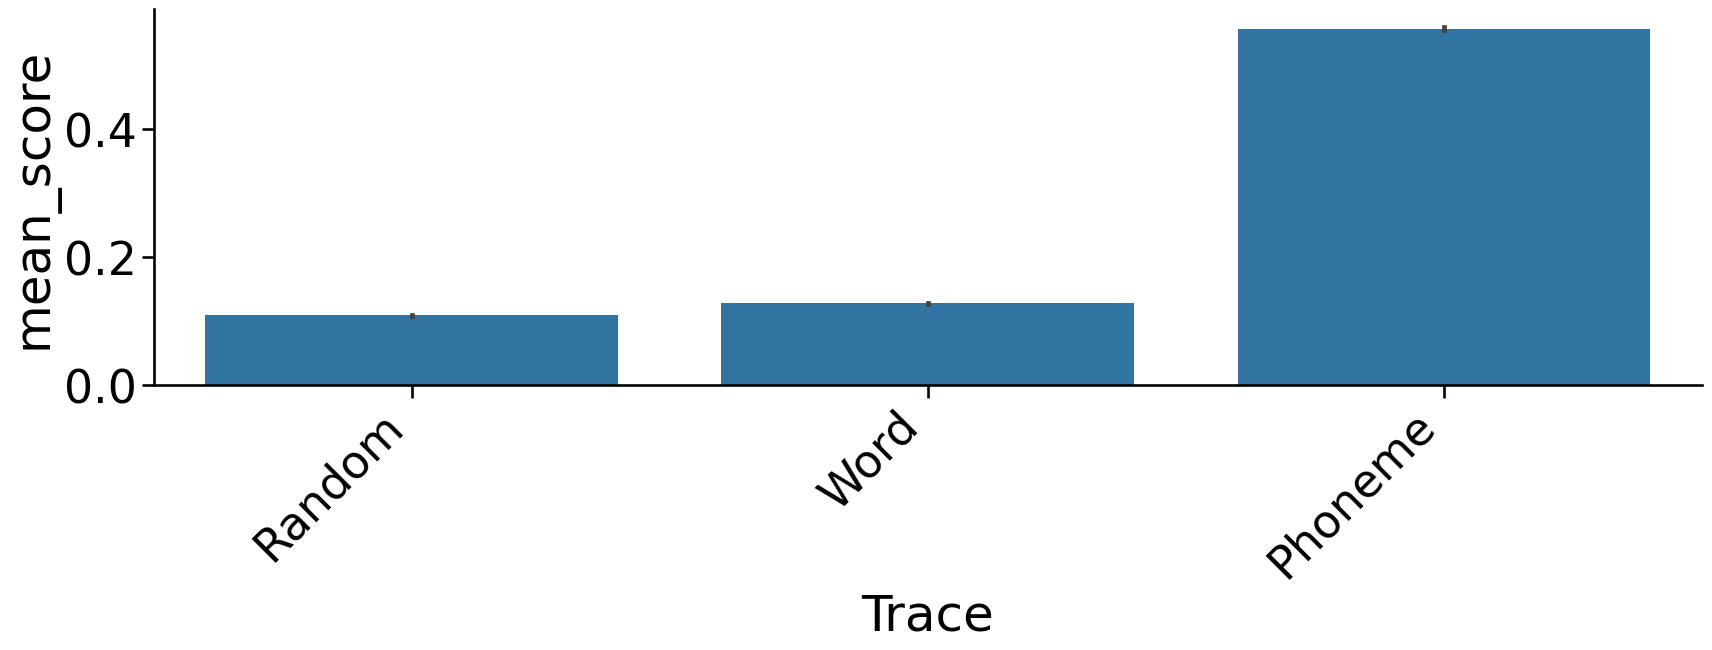

In [34]:
g = sns.FacetGrid(data=score_summary.reset_index(), margin_titles=True, height=6, aspect=3)
g.map(sns.barplot, "Trace", "mean_score", order=score_summary.groupby("Trace").mean().sort_values("mean_score").index, errorbar="se")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

Text(0.5, 0, 'Model')

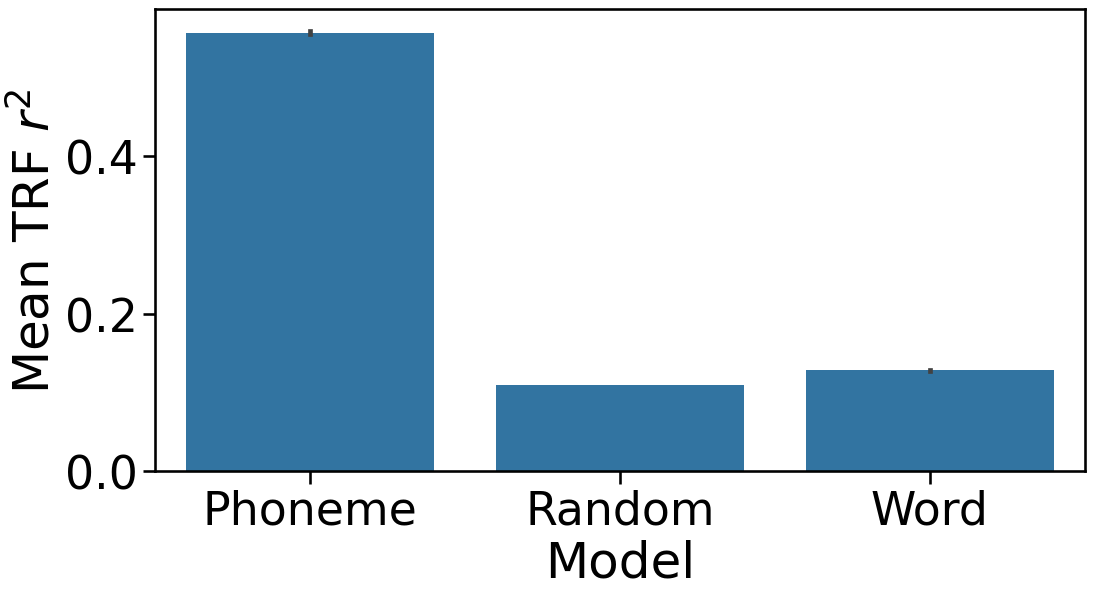

In [35]:
plot_data = score_summary.reset_index()
# plot_data = plot_data[plot_data.model == "w2v2_6_8"]

# Get mean and standard error of random model
# random_mean = score_summary.loc["w2v2_6_8"].loc["random"].mean_score.mean()
# random_se = score_summary.loc["w2v2_6_8"].loc["random"].mean_score.sem()

f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=plot_data, x="Trace", y="mean_score", errorbar="se", ax=ax)
ax.set_ylabel("Mean TRF $r^2$")
ax.set_xlabel("Model")

# Plot region of random performance
# ax.axhspan(random_mean - random_se, random_mean + random_se, color=sns.color_palette()[1])

## Feature selection results

In [19]:
feature_selection_paths = list(Path("../outputs/notebooks").glob("*/*/trf/trf_feature_selection_trajectory.csv"))
feature_selection = pd.concat([pd.read_csv(p) for p in feature_selection_paths],
                              keys=[(p.parents[2].name, p.parents[1].name) for p in feature_selection_paths],
                              names=["model", "equivalence"])

# feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

feature_selection.index.set_names("selection_idx", level=-1, inplace=True)
feature_selection = feature_selection.sort_index().reset_index()
feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

# Compute score deltas
feature_selection["score_diff"] = feature_selection.score.diff()
# Correct for boundaries
feature_selection.loc[feature_selection.selection_idx == 0, "score_diff"] = 0

feature_selection.head(10)

,model,equivalence,selection_idx,Unnamed: 0,category,score,score_diff
0,w2v2_6_32,random,0,0,NaN,0.017284,0.000000
1,w2v2_6_32,random,1,1,consonant_manner,0.072362,0.055078
2,w2v2_6_32,random,2,2,consonant_place,0.108654,0.036291
3,w2v2_6_32,random,3,3,vowel,0.126491,0.017838
4,w2v2_6_8,random,0,0,NaN,0.015372,0.000000
5,w2v2_6_8,random,1,1,consonant_place,0.080950,0.065578
6,w2v2_6_8,random,2,2,consonant_manner,0.114248,0.033298
7,w2v2_6_8,random,3,3,vowel,0.130620,0.016371
8,w2v2_6_32,random,0,0,NaN,0.019205,0.000000
9,w2v2_6_32,random,1,1,consonant_manner,0.099420,0.080214


In [20]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

plot_data = feature_selection[(feature_selection.model == "w2v2_6_8")]
plot_data["category"] = plot_data.category.fillna("baseline")

/tmp/ipykernel_4007273/3410982662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["category"] = plot_data.category.fillna("baseline")


In [22]:
links = []
for (model, equivalence), rows in plot_data.groupby(["model", "equivalence"]):
    for i1, i2 in zip(rows.index, rows.index[1:]):
        links.append({"source": rows.loc[i1].category, "target": rows.loc[i2].category, "value": rows.loc[i2, "score_diff"],
                      "type": f"{model} {equivalence}"})

# layout = Layout(width="1500", height="1200")
SankeyWidget(links=links)#, linkLabelFormat=".2f", layout=layout)

SankeyWidget(links=[{'source': 'baseline', 'target': 'consonant_manner', 'value': 0.4961562442384103, 'type': …